Source: https://github.com/explainingai-code/DDPM-Pytorch/tree/main

# Import

In [1]:
import numpy as np
from tqdm.notebook import tqdm

In [2]:
# %pip install pytorch-lightning

In [3]:
import pytorch_lightning as pl

In [4]:
import os
from torchvision.utils import make_grid

In [5]:
import torch
import torch.nn as nn
import torchvision

from torchvision import datasets
from torch.utils.data import DataLoader

from PIL import Image

# Data Load

In [6]:
train_dataset = datasets.MNIST(
    root='mnist',
    train=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: x * 2 - 1), # центрируем для лучшего обучения
    ]),
    download=True,
)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Model

## Scheduler

In [8]:
class LinearNoiseScheduler(nn.Module):
    def __init__(
        self,
        num_timesteps: int,
        beta_start: float,
        beta_end: float,
    ):
        super().__init__()
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        betas = torch.linspace(beta_start, beta_end, num_timesteps)
        alphas = (1.0 - betas)
        alpha_cum_prod = torch.cumprod(alphas, dim=0)
        sqrt_alpha_cum_prod = torch.sqrt(alpha_cum_prod)
        sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - alpha_cum_prod)

        self.register_buffer('betas', betas, persistent=False)
        self.register_buffer('alphas', alphas, persistent=False)
        self.register_buffer('alpha_cum_prod', alpha_cum_prod, persistent=False)
        self.register_buffer('sqrt_alpha_cum_prod', sqrt_alpha_cum_prod, persistent=False)
        self.register_buffer('sqrt_one_minus_alpha_cum_prod', sqrt_one_minus_alpha_cum_prod, persistent=False)

    def add_noise(self, original, noise: torch.Tensor, t) -> torch.Tensor:
        # original = [batch, n_ch, H, W]
        # t = [batch,]
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape) - 1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        return (
            sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise
        )

    def sample_prev_timestep(self, xt, noise_pred, t) -> tuple:
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)) / self.sqrt_alpha_cum_prod[t])
        x0 = torch.clamp(x0, -1.0, 1.0)

        mean = xt - ((self.betas[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod[t])
        mean = mean / torch.sqrt(self.alphas[t])

        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod[t - 1]) / (1.0 - self.alpha_cum_prod[t])
            variance = variance * self.betas[t]
            sigma = variance ** 0.5
            z = torch.randn_like(xt)
            return mean + sigma * z, x0

In [9]:
class TimeEmbedding(nn.Module):
    def __init__(
        self,
        t_emb_dim: int,
    ):
        super().__init__()
        assert t_emb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
        self.t_emb_dim = t_emb_dim
        self.half_t_emb_dim = t_emb_dim // 2

        factor = 10_000 ** (
            (
                torch.arange(start=0, end=self.half_t_emb_dim, dtype=torch.float32)
                 / (self.half_t_emb_dim)
            )
        )
        self.register_buffer('factor', factor, persistent=False)

    def forward(self, time_steps: torch.Tensor) -> torch.Tensor:
        t_emb = time_steps[:, None].repeat(1, self.half_t_emb_dim) / self.factor
        t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
        return t_emb

## Unet blocks

In [10]:
class ConvNormBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        norm_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
    ):
        super().__init__()

        self.model = nn.Sequential(
            nn.GroupNorm(norm_channels, in_channels),
            nn.SiLU(),
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.model(inputs)

In [11]:
class AttentionNormBlock(nn.Module):
    def __init__(
        self,
        num_heads: int,
        norm_channels: int,
        out_channels: int,
    ):
        super().__init__()
        self.norm_attn = nn.GroupNorm(norm_channels, out_channels)
        self.attn = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        batch_size, channels, h, w = inputs.shape
        out = inputs.reshape(batch_size, channels, h * w)
        out = self.norm_attn(out).transpose(1, 2)
        out_attn, _ = self.attn(out, out, out)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        return out_attn + inputs

In [12]:
class ResNetConvNormBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        t_emb_dim: int,
        norm_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
    ):
        super().__init__()
        self.t_emb_dim = t_emb_dim

        self.resnet_conv_first = ConvNormBlock(
            in_channels,
            out_channels,
            norm_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        if t_emb_dim is not None:
            self.t_emb_layers = nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
        self.resnet_conv_second = ConvNormBlock(
            out_channels,
            out_channels,
            norm_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.residual_input_conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1,
        )

    def forward(self, inputs: torch.Tensor, t_emb: torch.Tensor = None):
        out = self.resnet_conv_first(inputs)
        if self.t_emb_dim is not None:
            out = out + self.t_emb_layers(t_emb)[:, :, None, None]
        return self.resnet_conv_second(out) + self.residual_input_conv(inputs)

In [13]:
class DownBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        t_emb_dim: int,
        down_sample: bool,
        num_heads: int,
        num_layers: int,
        attn: bool,
        norm_channels: int,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.attn = attn
        self.t_emb_dim = t_emb_dim

        self.resnet_conv_blocks = nn.ModuleList(
            [
                ResNetConvNormBlock(
                    in_channels if i == 0 else out_channels,
                    out_channels,
                    t_emb_dim,
                    norm_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                )
                for i in range(num_layers)
            ]
        )

        if self.attn:
            self.attentions = nn.ModuleList(
                [
                    AttentionNormBlock(num_heads, norm_channels, out_channels)
                    for _ in range(num_layers)
                ]
            )

        self.down_sample_conv = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=4,
            stride=2,
            padding=1,
        ) if self.down_sample else nn.Identity()

    def forward(self, inputs: torch.Tensor, t_emb: torch.Tensor = None):
        out = inputs
        for i in range(self.num_layers):
            # Resnet block of Unet
            out = self.resnet_conv_blocks[i](out, t_emb)

            if self.attn:
                # Attention block of Unet
                out = self.attentions[i](out)

        # Downsample
        out = self.down_sample_conv(out)
        return out

In [14]:
class MidBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        t_emb_dim: int,
        num_heads: int,
        num_layers: int,
        norm_channels: int,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.t_emb_dim = t_emb_dim

        self.resnet_conv_blocks = nn.ModuleList(
            [
                ResNetConvNormBlock(
                    in_channels if i == 0 else out_channels,
                    out_channels,
                    t_emb_dim,
                    norm_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                )
                for i in range(num_layers + 1)
            ]
        )

        self.attentions = nn.ModuleList(
            [
                AttentionNormBlock(num_heads, norm_channels, out_channels)
                for _ in range(num_layers)
            ]
        )

    def forward(self, inputs: torch.Tensor, t_emb: torch.Tensor = None):
        out = inputs
        # First resnet block
        out = self.resnet_conv_blocks[0](out, t_emb)

        for i in range(self.num_layers):
            # Attention Block
            out = self.attentions[i](out)

            # Resnet Block
            out = self.resnet_conv_blocks[i + 1](out, t_emb)

        return out

In [15]:
class UpBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        t_emb_dim: int,
        up_sample: bool,
        num_heads: int,
        num_layers: int,
        attn: bool,
        norm_channels: int,
        concat_with_down: bool = False,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim
        self.attn = attn

        self.resnet_conv_blocks = nn.ModuleList(
            [
                ResNetConvNormBlock(
                    in_channels if i == 0 else out_channels,
                    out_channels,
                    t_emb_dim,
                    norm_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                )
                for i in range(num_layers)
            ]
        )

        if self.attn:
            self.attentions = nn.ModuleList(
              [
                  AttentionNormBlock(num_heads, norm_channels, out_channels)
                  for _ in range(num_layers)
              ]
          )

        self.up_sample_conv = nn.ConvTranspose2d(
            in_channels // 2 if concat_with_down else in_channels,
            in_channels // 2 if concat_with_down else in_channels,
            kernel_size=4,
            stride=2,
            padding=1,
        ) if self.up_sample else nn.Identity()

    def forward(self, inputs: torch.Tensor, out_down: torch.Tensor = None, t_emb: torch.Tensor = None):
        # Upsample
        inputs = self.up_sample_conv(inputs)

        # Concat with Downblock output
        if out_down is not None:
            inputs = torch.cat([inputs, out_down], dim=1)

        out = inputs
        for i in range(self.num_layers):
            # Resnet Block
            out = self.resnet_conv_blocks[i](out, t_emb)

            # Self Attention
            if self.attn:
                out = self.attentions[i](out)

        return out

## Unet

In [16]:
class Unet(nn.Module):
    def __init__(self, config: dict):
        super().__init__()
        self.in_channels = config['in_channels']
        self.down_channels = config['down_channels']
        self.mid_channels = config['mid_channels']
        self.up_channels = config['up_channels']
        self.t_emb_dim = config['t_emb_dim']
        self.down_sample = config['down_sample']
        self.up_sample = config['up_sample']
        self.attn = config['attn']
        self.num_heads = config['num_heads']
        self.num_down_layers = config['num_down_layers']
        self.num_mid_layers = config['num_mid_layers']
        self.num_up_layers = config['num_up_layers']
        self.norm_channels = config['norm_channels']
        self.conv_out_channels = config['conv_out_channels']
        self.concat_with_down = config['concat_with_down']

        self.time_emb = TimeEmbedding(self.t_emb_dim)
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
        )
        self.conv_in = nn.Conv2d(self.in_channels, self.down_channels[0], kernel_size=3, padding=1)
        self.downs = nn.ModuleList([
            DownBlock(
                self.down_channels[i],
                self.down_channels[i+1],
                self.t_emb_dim,
                down_sample=self.down_sample[i],
                num_heads=self.num_heads,
                num_layers=self.num_down_layers,
                attn=self.attn,
                norm_channels=self.norm_channels,
            ) for i in range(len(self.down_channels) - 1)
        ])
        self.mids = nn.ModuleList([
            MidBlock(
                self.mid_channels[i],
                self.mid_channels[i+1],
                self.t_emb_dim,
                num_heads=self.num_heads,
                num_layers=self.num_mid_layers,
                norm_channels=self.norm_channels,
            ) for i in range(len(self.mid_channels) - 1)
        ])
        self.ups = nn.ModuleList([
            UpBlock(
                self.down_channels[i] * 2,
                self.down_channels[i-1] if i != 0 else self.conv_out_channels,
                self.t_emb_dim,
                up_sample=self.down_sample[i],
                num_heads=self.num_heads,
                attn=self.attn,
                num_layers=self.num_up_layers,
                norm_channels=self.norm_channels,
                concat_with_down=self.concat_with_down,
            ) for i in reversed(range(len(self.down_channels) - 1))
        ])

        self.unet_out = nn.Sequential(
            nn.GroupNorm(self.norm_channels, self.conv_out_channels),
            nn.SiLU(),
            nn.Conv2d(self.conv_out_channels, self.in_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, t) -> torch.Tensor:
        out = self.conv_in(x)
        t_emb = self.time_emb(t.long())
        t_emb = self.t_proj(t_emb)

        down_outs = []
        for down in self.downs:
            # print(out.shape)
            down_outs.append(out)
            out = down(out, t_emb)

        for mid in self.mids:
            # print(out.shape)
            out = mid(out, t_emb)

        for up in self.ups:
            down_out = down_outs.pop()
            # print(out.shape, down_out.shape)
            out = up(out, down_out, t_emb)

        out = self.unet_out(out)

        return out

## Lightning wrapper

In [17]:
class DDPMLightning(pl.LightningModule):
    def __init__(
        self,
        model,
        noise_scheduler,
        criterion,
        lr: float,
    ):
        super().__init__()

        self.model = model
        self.noise_scheduler = noise_scheduler
        self.criterion = criterion
        self.lr = lr

    def forward(self, x):
        x = x[0]
        noise = torch.randn_like(x)
        # print(noise.device)

        # Sample timestep
        t = torch.randint(0, self.noise_scheduler.num_timesteps, (x.shape[0],), device=x.device)

        # Add noise to images according to timestep
        noisy_im = self.noise_scheduler.add_noise(x, noise, t)
        noise_pred = self.model(noisy_im, t)
        return noise_pred, noise

    def evaluate(self, batch, mode: str):
        noise_pred, noise = self(batch)
        loss = self.criterion(noise_pred, noise)
        return loss

    def training_step(self, batch, batch_idx):
        train_loss = self.evaluate(batch, 'train')
        self.log("train_loss", train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return train_loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.lr,
        )
        return optimizer

# Train

In [18]:
mnist_config = {
    'in_channels': 1,
    'down_channels': [32, 64, 128, 256],
    'mid_channels': [256, 256, 128],
    'up_channels': [256, 128, 64, 32],
    't_emb_dim': 128,
    'down_sample': [True, True, False],
    'up_sample': [False, True, True],
    'num_down_layers': 2,
    'num_mid_layers': 2,
    'num_up_layers': 2,
    'attn': True,
    'num_heads': 4,
    'norm_channels': 8,
    'conv_out_channels': 16,
    'concat_with_down': True,
}

In [19]:
def count_parameters(model: nn.Module):
    """Количество обучаемых параметров модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [20]:
x = torch.randn(3, 1, 28, 28)
t = torch.randint(0, 10, (1,))

In [21]:
unet = Unet(mnist_config)

In [22]:
print(f"The model has {count_parameters(unet):,} trainable parameters")

The model has 10,188,081 trainable parameters


In [23]:
scheduler = LinearNoiseScheduler(
    num_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
)

In [24]:
unet(x, t).shape

torch.Size([3, 1, 28, 28])

In [25]:
ddpm = DDPMLightning(unet, scheduler, torch.nn.MSELoss(), 1e-4)

max_epochs = 10
accumulate_grad_batches = 1

In [26]:
trainer = pl.Trainer(
    accelerator='cuda',
    max_epochs=max_epochs,
    accumulate_grad_batches=accumulate_grad_batches,
    precision="bf16-mixed",
    log_every_n_steps=1,
    enable_checkpointing=True,
    enable_progress_bar=True,
    gradient_clip_val=5,
    use_distributed_sampler=True,
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [27]:
trainer.fit(
    ddpm,
    train_dataloaders=train_loader,
)

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | model           | Unet                 | 10.2 M | train
1 | noise_scheduler | LinearNoiseScheduler | 0      | train
2 | criterion       | MSELoss              | 0      | train
-----------------------------------------------------------------
10.2 M    Trainable params
0         Non-trainable params
10.2 M    Total params
40.752    Total estimated model params size (MB)
380       Modules in train mode
0         Modules in eval mode
/home/max/common/lib/python3.12/sit

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [28]:
torch.save(ddpm.model.state_dict(), 'ddpm.sd')

# Sample

In [29]:
sample_config = {
    'num_samples': 100,
    'im_channels': 1,
    'im_size': 28,
    'num_grid_rows': 10,
    'task_name': 'mnist',
    'num_timesteps': 1000,
}

In [30]:
sample_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x.clamp(-1, 1)),
    torchvision.transforms.Lambda(lambda x: (x + 1) / 2),
    torchvision.transforms.ToPILImage()
])

In [31]:
def sample(model, scheduler, sample_config, sample_transforms, device):
    total_steps = sample_config['num_timesteps']
    xt = torch.randn(
        (
            sample_config['num_samples'],
            sample_config['im_channels'],
            sample_config['im_size'],
            sample_config['im_size'],
        ),
        device=device
    )
    
    for i in tqdm(reversed(range(total_steps)), total=total_steps):
        # Get prediction of noise
        t = torch.as_tensor(i, device=device).unsqueeze(0)
        noise_pred = model(xt, t)

        # Use scheduler to get x0 and xt-1
        xt, _ = scheduler.sample_prev_timestep(xt, noise_pred, t)

        grid = make_grid(xt, nrow=sample_config['num_grid_rows'])
        img = sample_transforms(grid)
        if not os.path.exists(os.path.join(sample_config['task_name'], 'samples')):
            os.mkdir(os.path.join(sample_config['task_name'], 'samples'))
        if (i % 100) == 0:
            img.save(os.path.join(sample_config['task_name'], 'samples', 'x0_{}.png'.format(i)))
            img.close()

In [32]:
device = 'cuda'

In [33]:
unet = Unet(mnist_config).eval().to(device)
unet.load_state_dict(torch.load('ddpm.sd'))

<All keys matched successfully>

In [34]:
scheduler = LinearNoiseScheduler(
    num_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
).to(device)

In [35]:
with torch.no_grad():
    sample(unet, scheduler, sample_config, sample_transforms, device)

  0%|          | 0/1000 [00:00<?, ?it/s]

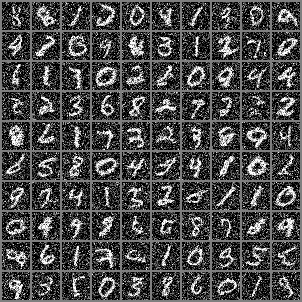

In [36]:
Image.open("mnist/samples/x0_200.png")

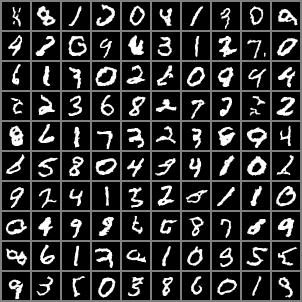

In [37]:
Image.open("mnist/samples/x0_0.png")